In [13]:
for i in range(4):
    if i == 0:
        print(range(20))
    elif 20*(i+1) > 66:
        print(range(20*i,66))
    else:
        print(range(20*i,20*(i+1)))

range(0, 20)
range(20, 40)
range(40, 60)
range(60, 66)


In [14]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import dgl # huggingface 같은 라이브러리

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
dist_mx = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data/sensor_graph/distances_kr_city_adj_mx.csv', encoding='cp949', index_col=0)

In [29]:
col = dist_mx.columns

In [30]:
dist_mx = dist_mx.values
distances = dist_mx[~np.isinf(dist_mx)].flatten()
std = distances.std()
adj_mx = np.exp(-np.square(dist_mx / std))
# Make the adjacent matrix symmetric by taking the max.
# adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])

# 최소 하나 연결하는 코드 추가

# Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
adj_mx[adj_mx < 0.5] = 0

sp_mx = sp.coo_matrix(adj_mx)
G = dgl.from_scipy(sp_mx)

In [33]:
deg = G.out_degrees()

pd.DataFrame({'city' : col, 'degree' : deg})

,city,degree
0,경기 양주시,65
1,경기 양평군,61
2,경기 가평군,58
3,경기 연천군,57
4,경기 여주시,57
...,...,...
224,강원 강릉시,14
225,강원 원주시,22
226,강원 춘천시,32
227,제주 서귀포시,2


In [35]:
tmp = pd.DataFrame({'a' : [1,2,3], 'b' : [2,3,4]})

In [37]:
tmp[['b', 'a']]

,b,a
0,2,1
1,3,2
2,4,3


In [ ]:
from curses import keyname


dict(keyname)

In [13]:
adj_mx

array([[1.        , 0.62363452, 0.79645519, ..., 0.53623474, 0.        ,
        0.        ],
       [0.62363452, 1.        , 0.88631944, ..., 0.83101136, 0.        ,
        0.        ],
       [0.79645519, 0.88631944, 1.        , ..., 0.90444042, 0.        ,
        0.        ],
       ...,
       [0.53623474, 0.83101136, 0.90444042, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.9816368 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.9816368 ,
        1.        ]])

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from model import *
from data_scaler import *

def validaion_loss(dataloader, model):
    n = len(dataloader)
    running_loss = 0.0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    model.train()
    return running_loss / n

def seq_data(data,sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(data) - sequence_length):
        x_seq.append(data[i:i+sequence_length])
        y_seq.append(data[i+sequence_length])
        
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)



def train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer, model, save_path):
    # criterion = nn.MSELoss()
    # num_epochs = 301
    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # save_path = f"save_model/{i}.pt"
    loss_graph = []
    min_val_loss, min_val_epoch = 500, 0 # 대에충
    n = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for data in train_loader:
            
            seq, target = data
            out = model(seq)
            loss = criterion(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        loss_graph.append(running_loss/n)
        val_loss = validaion_loss(val_loader, model)

        # Print training process
        if epoch % 100 == 0:
            print('[epoch : %d] train_loss : %.4f val_loss : %.4f'%(epoch, running_loss/n, val_loss))
             
        # Model save
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = epoch
            torch.save(model.state_dict(), save_path)
            
    return min_val_loss, min_val_epoch
        

            

def test_rnn(model, test_loader):
    with torch.no_grad():
        pred = []
        model.eval()
        for data in test_loader:
            seq, target = data
            out = model(seq)
            pred += out.cpu().tolist()
    return pred

def evaluate_metric(model, data_iter):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            #y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(x), -1).cpu().numpy()#.reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE
    
def seed_everything(seed = 42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'Seed set = {seed}')
    
seed_everything()

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Seed set = 42


cpu
[epoch : 0] train_loss : 0.4111 val_loss : 0.0138


/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.1734 val_loss : 0.0086
[epoch : 200] train_loss : 0.0921 val_loss : 0.0118
[epoch : 300] train_loss : 0.0587 val_loss : 0.0067
[epoch : 400] train_loss : 0.0377 val_loss : 0.0231
[epoch : 0] train_loss : 0.6219 val_loss : 0.0531
[epoch : 100] train_loss : 0.1794 val_loss : 0.0096
[epoch : 200] train_loss : 0.1231 val_loss : 0.0059
[epoch : 300] train_loss : 0.0704 val_loss : 0.0061
[epoch : 400] train_loss : 0.0979 val_loss : 0.0077
[[180.        ]
 [180.66666667]
 [199.        ]
 [230.33333333]
 [252.33333333]
 [267.66666667]
 [268.66666667]
 [245.66666667]
 [249.33333333]
 [298.33333333]
 [330.        ]
 [347.66666667]
 [322.        ]
 [317.66666667]
 [297.        ]
 [328.66666667]
 [397.33333333]
 [485.66666667]
 [499.33333333]
 [495.66666667]
 [433.        ]
 [403.66666667]
 [394.33333333]
 [452.33333333]
 [523.        ]
 [553.66666667]
 [547.66666667]
 [498.66666667]
 [442.33333333]]
[[0.9877574443817139], [1.058634638786316], [1.0556504726409912], [1.

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.0628 val_loss : 0.0038
[epoch : 200] train_loss : 0.0445 val_loss : 0.0055
[epoch : 300] train_loss : 0.0301 val_loss : 0.0083
[epoch : 400] train_loss : 0.0263 val_loss : 0.0080
[epoch : 0] train_loss : 0.5821 val_loss : 0.0869
[epoch : 100] train_loss : 0.0638 val_loss : 0.0034
[epoch : 200] train_loss : 0.0499 val_loss : 0.0068
[epoch : 300] train_loss : 0.0332 val_loss : 0.0047
[epoch : 400] train_loss : 0.0273 val_loss : 0.0051
[[1264.        ]
 [1235.33333333]
 [1393.        ]
 [1591.        ]
 [1745.66666667]
 [1740.33333333]
 [1682.33333333]
 [1501.33333333]
 [1449.66666667]
 [1687.66666667]
 [1974.66666667]
 [2143.66666667]
 [2127.66666667]
 [2057.        ]
 [1946.66666667]
 [1954.33333333]
 [2304.33333333]
 [2628.        ]
 [2807.66666667]
 [2766.        ]
 [2681.33333333]
 [2474.66666667]
 [2365.66666667]
 [2594.        ]
 [2831.33333333]
 [2904.33333333]
 [2723.66666667]
 [2411.33333333]
 [2091.33333333]]
[[1.0214675664901733], [1.01297950744628

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.0623 val_loss : 0.0045
[epoch : 200] train_loss : 0.0468 val_loss : 0.0055
[epoch : 300] train_loss : 0.0340 val_loss : 0.0048
[epoch : 400] train_loss : 0.0254 val_loss : 0.0039
[epoch : 0] train_loss : 0.4686 val_loss : 0.0728
[epoch : 100] train_loss : 0.0592 val_loss : 0.0047
[epoch : 200] train_loss : 0.0454 val_loss : 0.0080
[epoch : 300] train_loss : 0.0376 val_loss : 0.0047
[epoch : 400] train_loss : 0.0308 val_loss : 0.0042
[[ 932.33333333]
 [ 927.33333333]
 [1009.66666667]
 [1137.        ]
 [1170.66666667]
 [1204.66666667]
 [1138.33333333]
 [1057.66666667]
 [1064.33333333]
 [1266.33333333]
 [1484.66666667]
 [1642.        ]
 [1656.33333333]
 [1642.33333333]
 [1507.33333333]
 [1591.66666667]
 [1816.33333333]
 [2095.66666667]
 [2161.66666667]
 [2137.33333333]
 [2026.        ]
 [1823.        ]
 [1767.33333333]
 [1970.        ]
 [2229.33333333]
 [2306.33333333]
 [2165.33333333]
 [1937.66666667]
 [1660.66666667]]
[[0.9547574520111084], [1.01064729690551

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.3676 val_loss : 0.0527
[epoch : 200] train_loss : 0.2656 val_loss : 0.0504
[epoch : 300] train_loss : 0.2351 val_loss : 0.0551
[epoch : 400] train_loss : 0.2143 val_loss : 0.0863
[epoch : 0] train_loss : 0.9140 val_loss : 0.0587
[epoch : 100] train_loss : 0.3737 val_loss : 0.0485
[epoch : 200] train_loss : 0.2760 val_loss : 0.0492
[epoch : 300] train_loss : 0.2410 val_loss : 0.0600
[epoch : 400] train_loss : 0.2195 val_loss : 0.0549
[[ 37.33333333]
 [ 36.66666667]
 [ 36.66666667]
 [ 40.66666667]
 [ 40.        ]
 [ 47.        ]
 [ 47.        ]
 [ 52.        ]
 [ 48.66666667]
 [ 56.33333333]
 [ 61.        ]
 [ 65.66666667]
 [ 68.        ]
 [ 67.33333333]
 [ 67.33333333]
 [ 75.66666667]
 [ 91.33333333]
 [108.        ]
 [108.33333333]
 [106.33333333]
 [ 99.33333333]
 [ 90.66666667]
 [101.66666667]
 [111.33333333]
 [134.        ]
 [135.66666667]
 [130.33333333]
 [121.33333333]
 [109.66666667]]
[[1.1063283681869507], [1.0687998533248901], [0.9907488226890564], [1

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 0] train_loss : 0.6638 val_loss : 0.0430
[epoch : 100] train_loss : 0.2876 val_loss : 0.0388
[epoch : 200] train_loss : 0.2298 val_loss : 0.0392
[epoch : 300] train_loss : 0.1873 val_loss : 0.0597
[epoch : 400] train_loss : 0.1599 val_loss : 0.0630
[epoch : 0] train_loss : 0.7742 val_loss : 0.0447
[epoch : 100] train_loss : 0.3073 val_loss : 0.0332
[epoch : 200] train_loss : 0.2726 val_loss : 0.0477
[epoch : 300] train_loss : 0.2216 val_loss : 0.0425
[epoch : 400] train_loss : 0.1940 val_loss : 0.0538
[[53.33333333]
 [60.33333333]
 [52.33333333]
 [45.        ]
 [36.        ]
 [34.33333333]
 [39.66666667]
 [50.66666667]
 [55.        ]
 [50.        ]
 [43.        ]
 [40.66666667]
 [41.33333333]
 [42.33333333]
 [40.33333333]
 [42.66666667]
 [47.66666667]
 [46.66666667]
 [43.        ]
 [32.66666667]
 [43.        ]
 [44.        ]
 [59.33333333]
 [56.66666667]
 [59.        ]
 [48.33333333]
 [47.33333333]
 [42.66666667]
 [46.        ]]
[[1.1759052276611328], [0.9678213596343994], [0.

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.3358 val_loss : 0.0551
[epoch : 200] train_loss : 0.3038 val_loss : 0.0638
[epoch : 300] train_loss : 0.2369 val_loss : 0.0712
[epoch : 400] train_loss : 0.2065 val_loss : 0.0863
[epoch : 0] train_loss : 0.7429 val_loss : 0.0813
[epoch : 100] train_loss : 0.3368 val_loss : 0.0574
[epoch : 200] train_loss : 0.3077 val_loss : 0.0608
[epoch : 300] train_loss : 0.2552 val_loss : 0.1059
[epoch : 400] train_loss : 0.2220 val_loss : 0.1161
[[32.33333333]
 [27.        ]
 [39.        ]
 [43.33333333]
 [48.66666667]
 [32.        ]
 [30.33333333]
 [24.        ]
 [29.66666667]
 [39.66666667]
 [42.66666667]
 [45.        ]
 [41.33333333]
 [42.66666667]
 [44.33333333]
 [51.33333333]
 [59.66666667]
 [68.        ]
 [69.33333333]
 [70.        ]
 [73.33333333]
 [74.        ]
 [70.        ]
 [61.33333333]
 [57.        ]
 [57.66666667]
 [49.33333333]
 [50.        ]
 [47.33333333]]
[[1.0205014944076538], [0.9721478223800659], [1.371827483177185], [1.1064739227294922], [0.8935420

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.2693 val_loss : 0.0298
[epoch : 200] train_loss : 0.1763 val_loss : 0.0321
[epoch : 300] train_loss : 0.1428 val_loss : 0.0315
[epoch : 400] train_loss : 0.1221 val_loss : 0.0350
[epoch : 0] train_loss : 0.7385 val_loss : 0.0781
[epoch : 100] train_loss : 0.2994 val_loss : 0.0317
[epoch : 200] train_loss : 0.2259 val_loss : 0.0377
[epoch : 300] train_loss : 0.2610 val_loss : 0.0325
[epoch : 400] train_loss : 0.1428 val_loss : 0.0298
[[ 48.33333333]
 [ 53.33333333]
 [ 64.        ]
 [ 85.33333333]
 [ 84.        ]
 [ 95.33333333]
 [ 94.        ]
 [ 96.33333333]
 [ 87.66666667]
 [ 79.33333333]
 [ 79.33333333]
 [ 81.        ]
 [ 93.33333333]
 [109.        ]
 [120.33333333]
 [129.66666667]
 [125.66666667]
 [132.66666667]
 [135.33333333]
 [152.        ]
 [148.66666667]
 [150.        ]
 [148.66666667]
 [156.33333333]
 [163.33333333]
 [167.        ]
 [176.33333333]
 [157.        ]
 [145.        ]]
[[0.9899678230285645], [1.1264859437942505], [1.0488113164901733], [1

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 0] train_loss : 0.5932 val_loss : 0.0433
[epoch : 100] train_loss : 0.1836 val_loss : 0.0270
[epoch : 200] train_loss : 0.1010 val_loss : 0.0364
[epoch : 300] train_loss : 0.0638 val_loss : 0.0400
[epoch : 400] train_loss : 0.0447 val_loss : 0.0427
[epoch : 0] train_loss : 0.6948 val_loss : 0.0689
[epoch : 100] train_loss : 0.1787 val_loss : 0.0268
[epoch : 200] train_loss : 0.1120 val_loss : 0.0435
[epoch : 300] train_loss : 0.0841 val_loss : 0.0390
[epoch : 400] train_loss : 0.0542 val_loss : 0.0702
[[ 41.66666667]
 [ 47.33333333]
 [ 60.        ]
 [ 77.33333333]
 [100.66666667]
 [106.66666667]
 [ 97.66666667]
 [ 79.33333333]
 [ 75.66666667]
 [ 83.33333333]
 [ 90.        ]
 [ 92.66666667]
 [ 92.66666667]
 [100.        ]
 [124.        ]
 [140.        ]
 [149.        ]
 [153.        ]
 [155.        ]
 [158.66666667]
 [155.        ]
 [162.66666667]
 [167.33333333]
 [183.66666667]
 [183.33333333]
 [176.        ]
 [149.66666667]
 [127.66666667]
 [119.        ]]
[[1.066320538520813

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.2618 val_loss : 0.0852
[epoch : 200] train_loss : 0.1014 val_loss : 0.1310
[epoch : 300] train_loss : 0.0784 val_loss : 0.1388
[epoch : 400] train_loss : 0.0663 val_loss : 0.1562
[epoch : 0] train_loss : 0.9092 val_loss : 0.0878
[epoch : 100] train_loss : 0.3144 val_loss : 0.0889
[epoch : 200] train_loss : 0.1318 val_loss : 0.0947
[epoch : 300] train_loss : 0.0926 val_loss : 0.1271
[epoch : 400] train_loss : 0.0703 val_loss : 0.1262
[[ 75.33333333]
 [ 81.33333333]
 [ 80.        ]
 [ 84.33333333]
 [ 76.        ]
 [ 76.66666667]
 [ 88.        ]
 [ 87.33333333]
 [ 85.33333333]
 [ 91.66666667]
 [101.66666667]
 [115.        ]
 [112.66666667]
 [125.        ]
 [121.66666667]
 [131.33333333]
 [157.66666667]
 [186.33333333]
 [205.        ]
 [196.        ]
 [203.33333333]
 [189.        ]
 [192.66666667]
 [184.66666667]
 [187.        ]
 [197.        ]
 [209.66666667]
 [207.        ]
 [186.66666667]]
[[1.0359954833984375], [1.0352197885513306], [1.030295968055725], [1.

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.2349 val_loss : 0.0222
[epoch : 200] train_loss : 0.1562 val_loss : 0.0237
[epoch : 300] train_loss : 0.1133 val_loss : 0.0281
[epoch : 400] train_loss : 0.1026 val_loss : 0.0339
[epoch : 0] train_loss : 0.6661 val_loss : 0.0362
[epoch : 100] train_loss : 0.2525 val_loss : 0.0236
[epoch : 200] train_loss : 0.2040 val_loss : 0.0270
[epoch : 300] train_loss : 0.1603 val_loss : 0.0279
[epoch : 400] train_loss : 0.1360 val_loss : 0.0235
[[ 24.        ]
 [ 29.33333333]
 [ 29.66666667]
 [ 33.33333333]
 [ 34.        ]
 [ 32.33333333]
 [ 30.33333333]
 [ 31.        ]
 [ 40.        ]
 [ 48.        ]
 [ 66.66666667]
 [ 74.        ]
 [ 85.66666667]
 [ 72.66666667]
 [ 67.33333333]
 [ 63.66666667]
 [ 74.33333333]
 [ 85.        ]
 [ 83.        ]
 [ 86.66666667]
 [ 84.66666667]
 [ 89.33333333]
 [ 88.        ]
 [ 85.66666667]
 [122.66666667]
 [131.66666667]
 [138.        ]
 [ 94.33333333]
 [ 82.33333333]]
[[0.9836394786834717], [0.9824973940849304], [1.071871042251587], [0.

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 0] train_loss : 0.7914 val_loss : 0.1212
[epoch : 100] train_loss : 0.3169 val_loss : 0.0900
[epoch : 200] train_loss : 0.1973 val_loss : 0.1069
[epoch : 300] train_loss : 0.1327 val_loss : 0.1362
[epoch : 400] train_loss : 0.1153 val_loss : 0.1428
[epoch : 0] train_loss : 0.7178 val_loss : 0.1042
[epoch : 100] train_loss : 0.3462 val_loss : 0.0904
[epoch : 200] train_loss : 0.2298 val_loss : 0.1387
[epoch : 300] train_loss : 0.1538 val_loss : 0.1659
[epoch : 400] train_loss : 0.1211 val_loss : 0.1928
[[20.33333333]
 [23.66666667]
 [25.        ]
 [29.33333333]
 [29.        ]
 [30.        ]
 [35.        ]
 [34.33333333]
 [35.        ]
 [25.        ]
 [26.66666667]
 [24.33333333]
 [23.        ]
 [24.66666667]
 [33.33333333]
 [46.33333333]
 [51.33333333]
 [48.66666667]
 [47.33333333]
 [45.        ]
 [40.66666667]
 [34.66666667]
 [32.66666667]
 [34.        ]
 [33.        ]
 [32.33333333]
 [30.33333333]
 [27.        ]
 [27.        ]]
[[1.097475528717041], [1.1504820585250854], [1.0

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.3172 val_loss : 0.0407
[epoch : 200] train_loss : 0.1967 val_loss : 0.0119
[epoch : 300] train_loss : 0.1498 val_loss : 0.0352
[epoch : 400] train_loss : 0.1142 val_loss : 0.0418
[epoch : 0] train_loss : 0.9007 val_loss : 0.0529
[epoch : 100] train_loss : 0.3744 val_loss : 0.0101
[epoch : 200] train_loss : 0.3290 val_loss : 0.0090
[epoch : 300] train_loss : 0.2047 val_loss : 0.0230
[epoch : 400] train_loss : 0.1718 val_loss : 0.0258
[[ 78.        ]
 [ 81.66666667]
 [ 79.        ]
 [ 94.66666667]
 [100.66666667]
 [111.33333333]
 [115.        ]
 [123.        ]
 [120.        ]
 [125.        ]
 [137.        ]
 [158.66666667]
 [190.66666667]
 [199.33333333]
 [193.33333333]
 [183.33333333]
 [205.        ]
 [243.33333333]
 [284.66666667]
 [304.        ]
 [307.33333333]
 [263.66666667]
 [253.        ]
 [271.        ]
 [337.        ]
 [380.        ]
 [383.        ]
 [367.66666667]
 [316.        ]]
[[1.0197539329528809], [1.0335057973861694], [1.0822559595108032], [1

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.3972 val_loss : 0.1989
[epoch : 200] train_loss : 0.2060 val_loss : 0.2939
[epoch : 300] train_loss : 0.1288 val_loss : 0.4863
[epoch : 400] train_loss : 0.1047 val_loss : 0.4943
[epoch : 0] train_loss : 0.9179 val_loss : 0.2796
[epoch : 100] train_loss : 0.4481 val_loss : 0.2178
[epoch : 200] train_loss : 0.2776 val_loss : 0.2471
[epoch : 300] train_loss : 0.1508 val_loss : 0.2879
[epoch : 400] train_loss : 0.1109 val_loss : 0.4318
[[ 5.33333333]
 [ 6.        ]
 [ 6.33333333]
 [12.33333333]
 [15.33333333]
 [16.66666667]
 [12.66666667]
 [12.33333333]
 [15.        ]
 [16.66666667]
 [15.        ]
 [10.66666667]
 [ 9.        ]
 [12.66666667]
 [15.33333333]
 [16.66666667]
 [14.        ]
 [13.66666667]
 [12.33333333]
 [11.66666667]
 [ 9.66666667]
 [10.66666667]
 [14.66666667]
 [20.        ]
 [25.        ]
 [27.        ]
 [35.        ]
 [34.33333333]
 [30.        ]]
[[1.0425829887390137], [1.0107347965240479], [0.805168092250824], [1.0307095050811768], [1.0146971

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.1880 val_loss : 0.0231
[epoch : 200] train_loss : 0.1500 val_loss : 0.0209
[epoch : 300] train_loss : 0.1195 val_loss : 0.0226
[epoch : 400] train_loss : 0.1041 val_loss : 0.0397
[epoch : 0] train_loss : 0.5255 val_loss : 0.0316
[epoch : 100] train_loss : 0.1897 val_loss : 0.0213
[epoch : 200] train_loss : 0.1690 val_loss : 0.0236
[epoch : 300] train_loss : 0.1442 val_loss : 0.0210
[epoch : 400] train_loss : 0.1220 val_loss : 0.0357
[[ 66.        ]
 [ 60.66666667]
 [ 66.        ]
 [ 68.66666667]
 [ 72.66666667]
 [ 71.33333333]
 [ 68.66666667]
 [ 66.66666667]
 [ 72.66666667]
 [100.        ]
 [112.66666667]
 [120.33333333]
 [114.        ]
 [122.66666667]
 [111.        ]
 [106.        ]
 [114.33333333]
 [134.66666667]
 [150.        ]
 [148.        ]
 [136.        ]
 [122.33333333]
 [125.        ]
 [129.33333333]
 [146.66666667]
 [139.33333333]
 [131.33333333]
 [114.66666667]
 [106.33333333]]
[[1.0392462015151978], [1.0015895366668701], [1.0835949182510376], [1

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.5640 val_loss : 0.0411
[epoch : 200] train_loss : 0.1318 val_loss : 0.0468
[epoch : 300] train_loss : 0.1050 val_loss : 0.0497
[epoch : 400] train_loss : 0.0922 val_loss : 0.0469
[epoch : 0] train_loss : 1.9160 val_loss : 0.0374
[epoch : 100] train_loss : 0.8956 val_loss : 0.0637
[epoch : 200] train_loss : 0.1682 val_loss : 0.0984
[epoch : 300] train_loss : 0.1265 val_loss : 0.0906
[epoch : 400] train_loss : 0.1018 val_loss : 0.0721
[[ 37.33333333]
 [ 49.        ]
 [ 51.33333333]
 [ 56.        ]
 [ 49.33333333]
 [ 44.33333333]
 [ 45.        ]
 [ 44.        ]
 [ 46.66666667]
 [ 61.        ]
 [101.33333333]
 [119.33333333]
 [131.66666667]
 [119.        ]
 [123.        ]
 [120.66666667]
 [141.        ]
 [157.66666667]
 [172.33333333]
 [148.33333333]
 [131.33333333]
 [102.33333333]
 [114.66666667]
 [132.        ]
 [149.33333333]
 [153.33333333]
 [142.66666667]
 [141.66666667]
 [124.66666667]]
[[1.0746568441390991], [1.0676143169403076], [1.1443766355514526], [0

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 0] train_loss : 0.6101 val_loss : 0.0827
[epoch : 100] train_loss : 0.3004 val_loss : 0.0713
[epoch : 200] train_loss : 0.1446 val_loss : 0.0628
[epoch : 300] train_loss : 0.1102 val_loss : 0.0747
[epoch : 400] train_loss : 0.0941 val_loss : 0.0987
[epoch : 0] train_loss : 0.6923 val_loss : 0.0690
[epoch : 100] train_loss : 0.3126 val_loss : 0.0698
[epoch : 200] train_loss : 0.1754 val_loss : 0.0654
[epoch : 300] train_loss : 0.1275 val_loss : 0.0824
[epoch : 400] train_loss : 0.0999 val_loss : 0.0891
[[ 6.66666667]
 [ 8.66666667]
 [11.        ]
 [11.        ]
 [10.66666667]
 [ 8.33333333]
 [ 6.33333333]
 [ 3.33333333]
 [ 6.33333333]
 [12.33333333]
 [18.33333333]
 [18.        ]
 [17.        ]
 [13.33333333]
 [12.33333333]
 [13.33333333]
 [24.33333333]
 [35.33333333]
 [40.33333333]
 [40.33333333]
 [39.        ]
 [44.        ]
 [65.33333333]
 [74.33333333]
 [81.        ]
 [58.66666667]
 [50.        ]
 [35.33333333]
 [32.33333333]]
[[1.131059169769287], [1.1191728115081787], [1.0

/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: divide by zero encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values
/Users/jeonjunhwi/문서/Projects/Master_GNN/stgcn_wave/data_scaler.py:14: RuntimeWarning: invalid value encountered in true_divide
  val = df.iloc[1:].values / df.iloc[:-1].values


[epoch : 100] train_loss : 0.1614 val_loss : 0.0136
[epoch : 200] train_loss : 0.0804 val_loss : 0.0172
[epoch : 300] train_loss : 0.0534 val_loss : 0.0275
[epoch : 400] train_loss : 0.0458 val_loss : 0.0312
[epoch : 0] train_loss : 0.7746 val_loss : 0.0199
[epoch : 100] train_loss : 0.1905 val_loss : 0.0161
[epoch : 200] train_loss : 0.1293 val_loss : 0.0152
[epoch : 300] train_loss : 0.0781 val_loss : 0.0249
[epoch : 400] train_loss : 0.0565 val_loss : 0.0159
[[ 55.66666667]
 [ 55.66666667]
 [137.33333333]
 [157.66666667]
 [162.66666667]
 [ 90.33333333]
 [ 91.        ]
 [ 84.66666667]
 [ 84.33333333]
 [ 92.66666667]
 [121.66666667]
 [151.        ]
 [159.        ]
 [165.        ]
 [158.33333333]
 [157.66666667]
 [173.66666667]
 [190.        ]
 [198.66666667]
 [182.        ]
 [179.66666667]
 [177.33333333]
 [194.66666667]
 [189.66666667]
 [202.        ]
 [196.33333333]
 [208.66666667]
 [205.66666667]
 [183.33333333]]
[[0.9661386013031006], [0.9898697733879089], [1.2698513269424438], [1

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


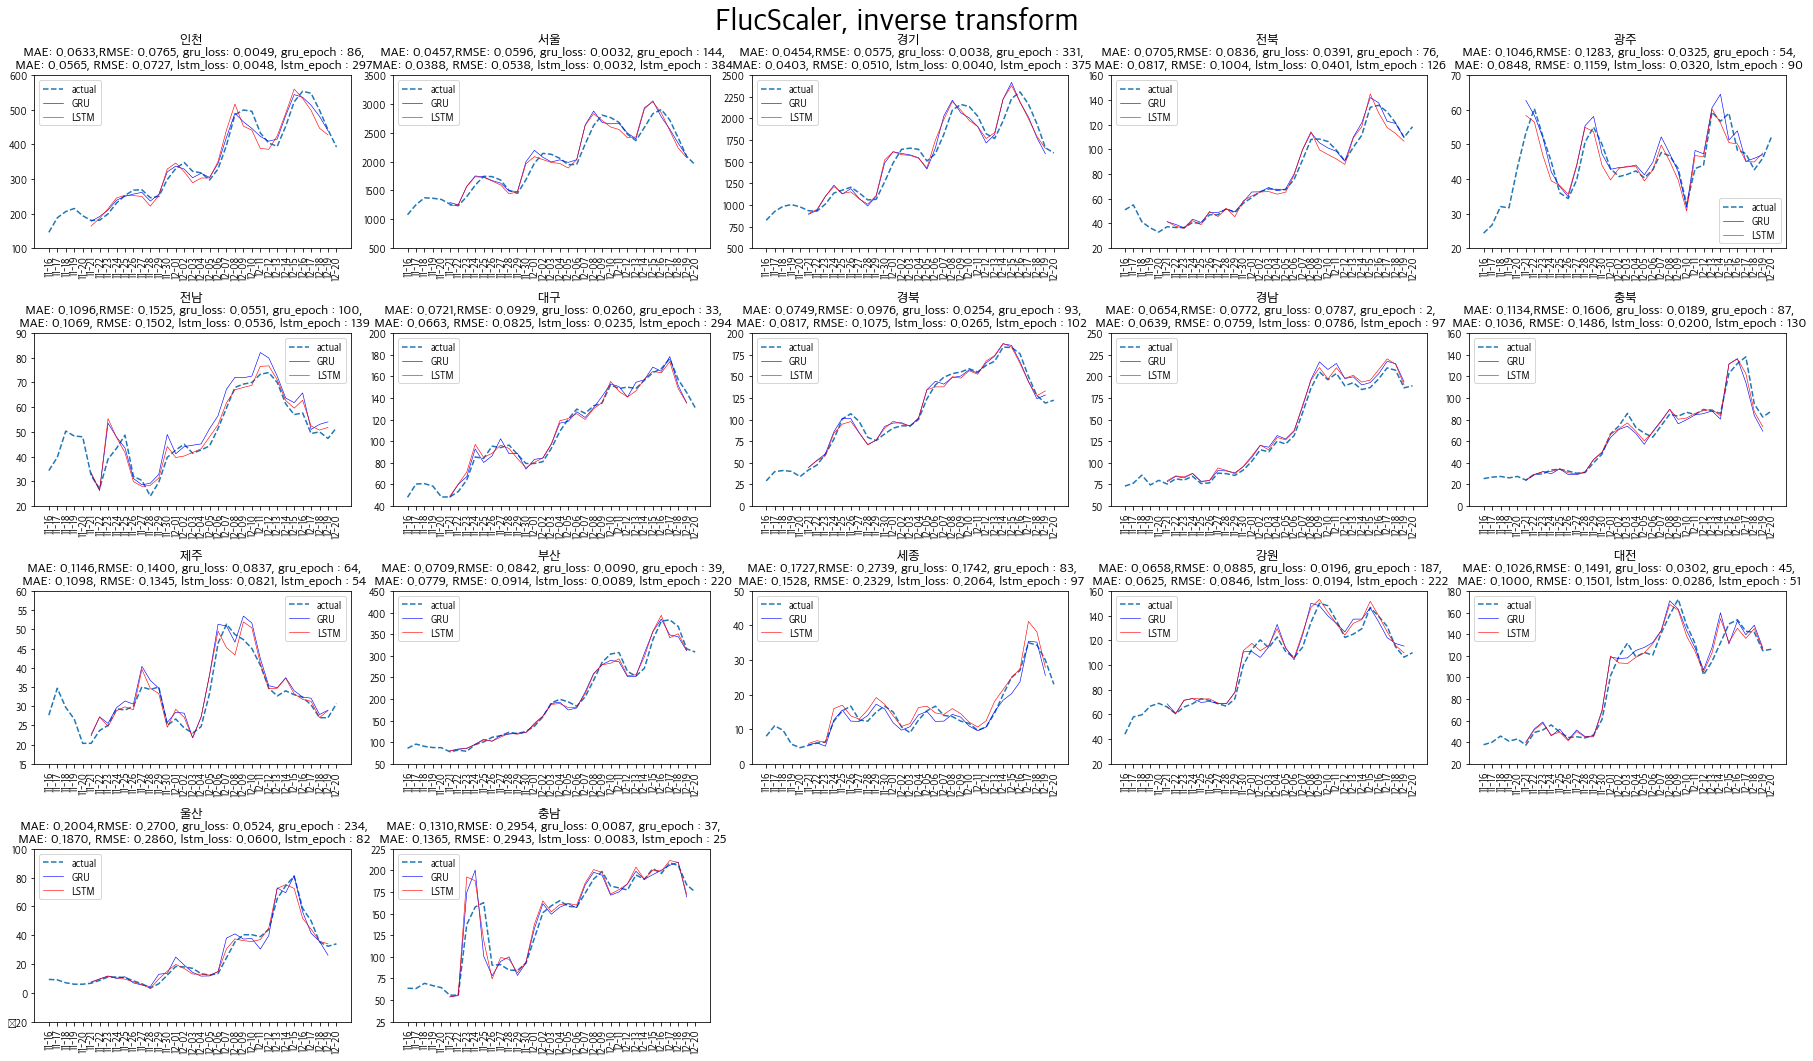

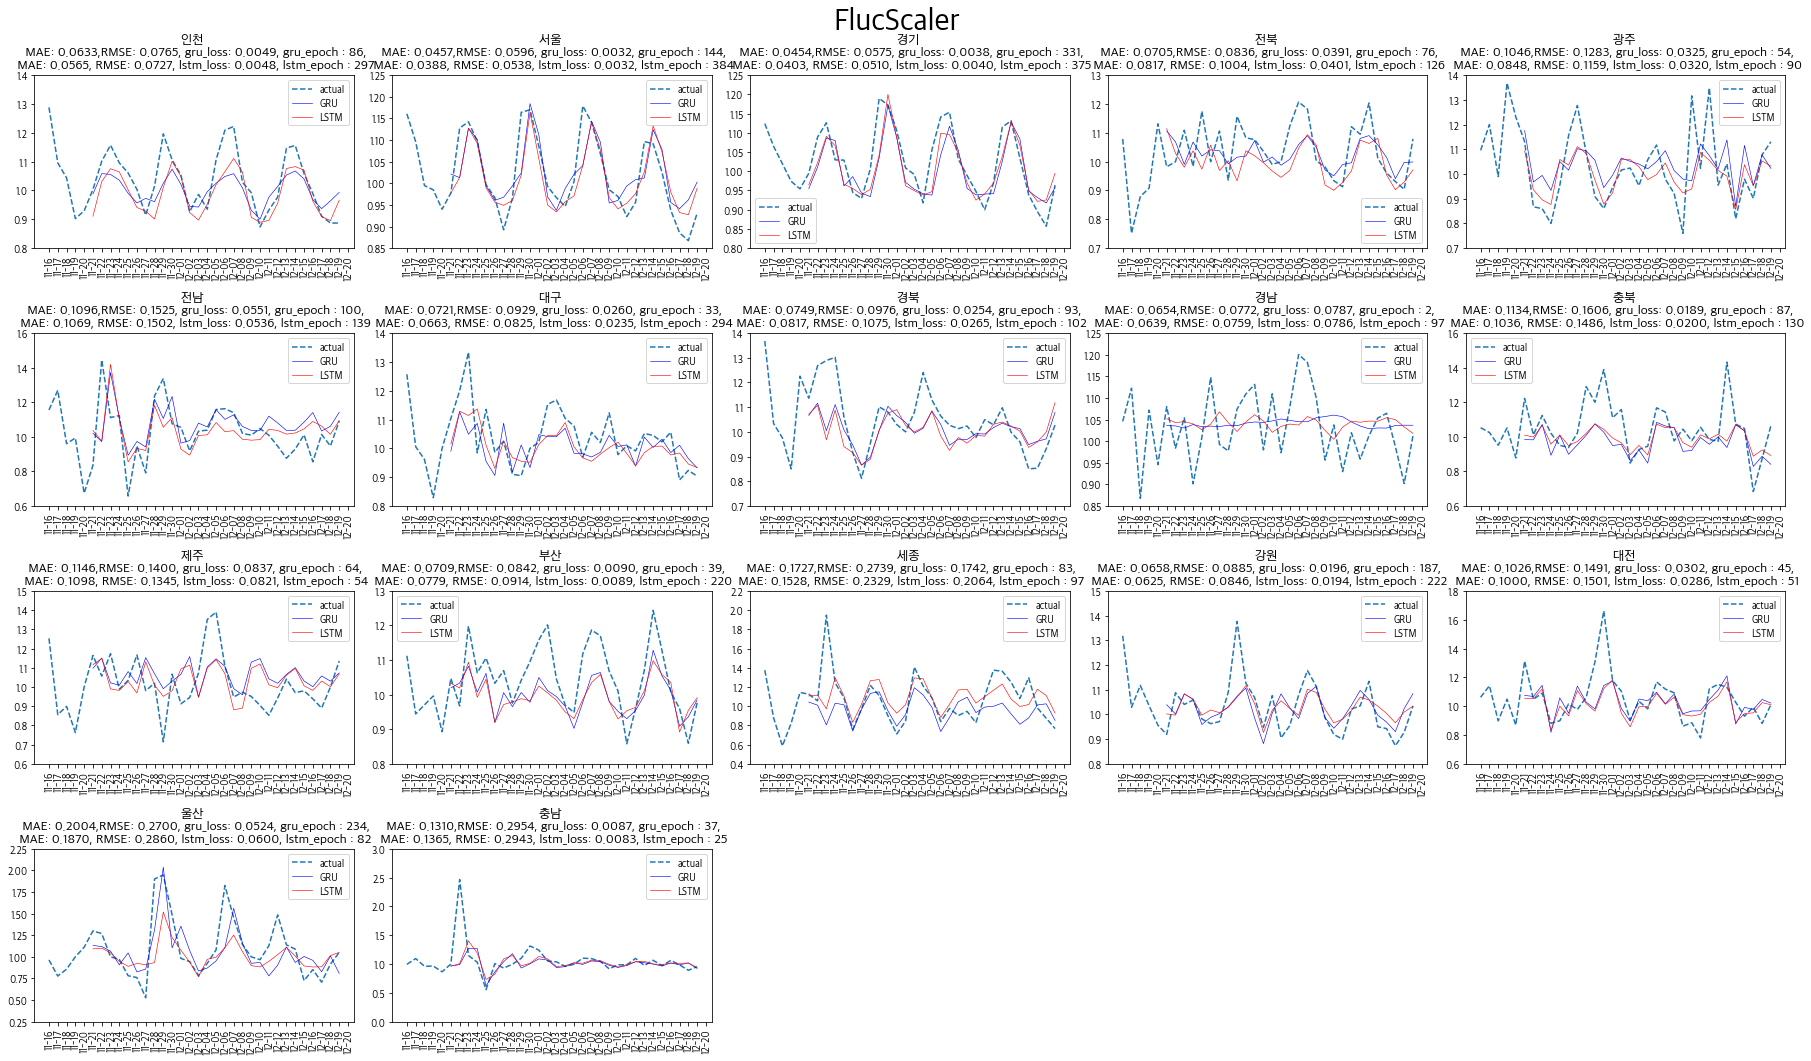

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import font_manager, rc
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family = font)

# df = pd.read_csv('data/state-kr-R.csv', index_col=0)
# df = pd.read_csv('data/state-kr.csv', index_col=0)
df = pd.read_csv('data/smoothing_3_state_mean.csv', index_col=0, encoding='cp949')
df = df.iloc[:700] # 12월 까지만 해보자

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

### 컬럼을 숫자로 바꿔줌 ###
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region
df.columns = list(region_dict.keys())

len_train = round(len(df)*0.85)
len_val = round(len(df)*0.1)
sequence_length = 5
fig = plt.figure(figsize=(25,15), facecolor='white') # inverse_transform
fig2 = plt.figure(figsize=(25,15), facecolor='white') # scaling data
suptitle_1 = 'FlucScaler, inverse transform'
suptitle_2 = 'FlucScaler'
# for i in [0]:
for i in list(df.columns):

    train = df[[i]][:len_train]
    val = df[[i]][ len_train: len_train + len_val]
    test = df[[i]][ len_train + len_val:]
    
    # scaler = MinMaxScaler()
    # scaler = StandardScaler()
    scaler = FluctuationScaler(df[[i]])
    # scaler = LogScaler(log_category='log10')

    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    x_train_seq, y_train_seq = seq_data(train, sequence_length)
    x_val_seq, y_val_seq = seq_data(val, sequence_length)
    x_test_seq, y_test_seq = seq_data(test, sequence_length)

    train_torch = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    val_torch = torch.utils.data.TensorDataset(x_val_seq, y_val_seq)
    test_torch = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
    batch_size = 16
    train_loader = torch.utils.data.DataLoader(dataset=train_torch, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_torch, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_torch, batch_size=batch_size, shuffle=False)

    input_size = x_train_seq.size(2) # 이거 뭔지 알아내야함.
    num_layers = 2
    hidden_size = 32
    output_size = 32

    model_1 = GRU(input_size = input_size,
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)
    
    model_2 = LSTM(input_size = input_size,
                    hidden_size = hidden_size,
                    # output_size = output_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)

    criterion = nn.MSELoss()
    num_epochs = 401
    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
    
    save_path_1 = f"save_model/gru_smooth_3_{suptitle_1}_{i}.pt"
    save_path_2 = f"save_model/lstm_smooth_3_{suptitle_2}_{i}.pt"
    val_loss_1, epoch_1 = train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer_1, model_1, save_path_1)
    val_loss_2, epoch_2 = train_rnn(train_loader, val_loader, criterion, num_epochs, optimizer_2, model_2, save_path_2)

    best_model_1 = GRU(input_size = input_size,
                    hidden_size = hidden_size,
                    sequence_length = sequence_length,
                    num_layers = num_layers,
                    device = device).to(device)
    best_model_1.load_state_dict(torch.load(save_path_1))
    
    best_model_2 = LSTM(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers,
                device = device).to(device)
    best_model_2.load_state_dict(torch.load(save_path_2))

    MAE_1, MAPE_1, RMSE_1 = evaluate_metric(best_model_1, test_loader)
    MAE_2, MAPE_2, RMSE_2 = evaluate_metric(best_model_2, test_loader)

    pred_1 = test_rnn(best_model_1, test_loader)
    pred_2 = test_rnn(best_model_2, test_loader)
    
    #######################
    # Scaling Data Figure #
    #######################
    pred_1_o = [[None]]*sequence_length + pred_1 # y 값은 5일 학습하고 다음날을 예측한 것이므로, shift 해줘야함
    pred_2_o = [[None]]*sequence_length + pred_2
    
    ax2 = fig2.add_subplot(4,5,int(i)+1)
    ax2.plot(test,'--')
    ax2.plot(pred_1_o,'b',linewidth=0.6)
    ax2.plot(pred_2_o,'r',linewidth=0.6)
    ax2.legend(['actual', 'GRU', 'LSTM'])
    
    # xlabels = list(df.index[len_train + len_val:])
    xlabels = [i[5:] for i in list(df.index[len_train + len_val:])]
    ax2.set_xticks(ticks = [i for i in range(len(xlabels))], labels = xlabels, rotation=90)
    yticks_ = ax2.get_yticks()
    ax2.set_yticks(yticks_, fontsize = 15)
    
    title_ = f"{region_dict[int(i)]} \n MAE: {MAE_1:.4f},RMSE: {RMSE_1:.4f}, gru_loss: {val_loss_1:.4f}, gru_epoch : {epoch_1},\n MAE: {MAE_2:.4f}, RMSE: {RMSE_2:.4f}, lstm_loss: {val_loss_2:.4f}, lstm_epoch : {epoch_2}"
    ax2.set_title(title_ ,fontsize = 13)

    ########################
    # Original Data Figure #
    ########################
    # print(pred_1)
    # print(pred_2)
    
    pred_1 = [[None]]*sequence_length + scaler.inverse_transform(pred_1).tolist() # y 값은 5일 학습하고 다음날을 예측한 것이므로, shift 해줘야함
    pred_2 = [[None]]*sequence_length + scaler.inverse_transform(pred_2).tolist()
    
    # print(pred_1)
    # print(pred_2)
    
    ax1 = fig.add_subplot(4,5,int(i)+1)
    ax1.plot(df[i][len_train + len_val:].values,'--')
    ax1.plot(pred_1,'b',linewidth=0.6)
    ax1.plot(pred_2,'r',linewidth=0.6)
    ax1.legend(['actual', 'GRU', 'LSTM'])
    
    # xlabels = list(df.index[len_train + len_val:])
    xlabels = [i[5:] for i in list(df.index[len_train + len_val:])]
    ax1.set_xticks(ticks = [i for i in range(len(xlabels))], labels = xlabels, rotation=90)
    yticks_ = ax1.get_yticks()
    ax1.set_yticks(yticks_, fontsize = 15)
    
    title_ = f"{region_dict[int(i)]} \n MAE: {MAE_1:.4f},RMSE: {RMSE_1:.4f}, gru_loss: {val_loss_1:.4f}, gru_epoch : {epoch_1},\n MAE: {MAE_2:.4f}, RMSE: {RMSE_2:.4f}, lstm_loss: {val_loss_2:.4f}, lstm_epoch : {epoch_2}"
    ax1.set_title(title_ ,fontsize = 13)

    


fig.suptitle(suptitle_1, fontsize=30)
fig.tight_layout()
fig.savefig(f'Figures/compare_rnn_original_{suptitle_1}.png')

fig2.suptitle(suptitle_2, fontsize=30)
fig2.tight_layout()
fig2.savefig(f'Figures/compare_rnn_scale_{suptitle_2}.png')

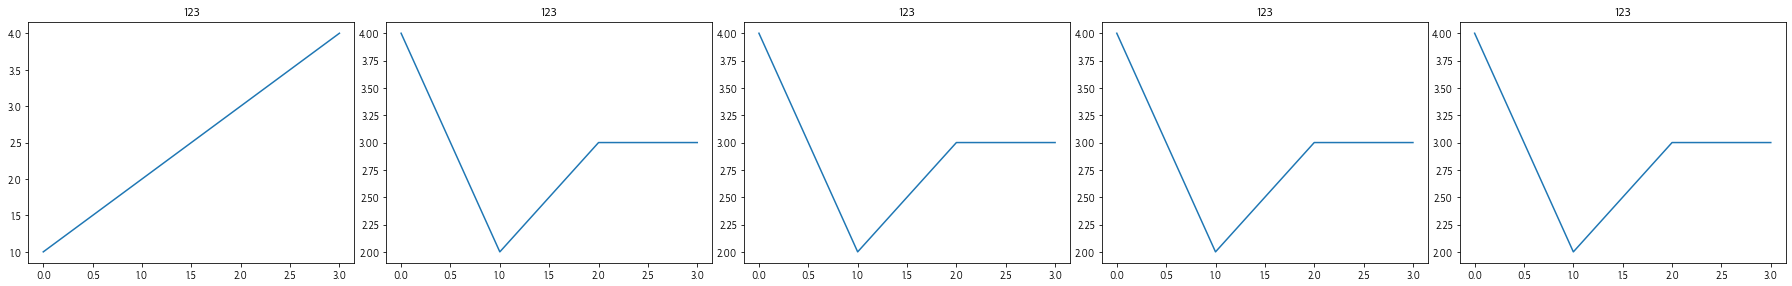

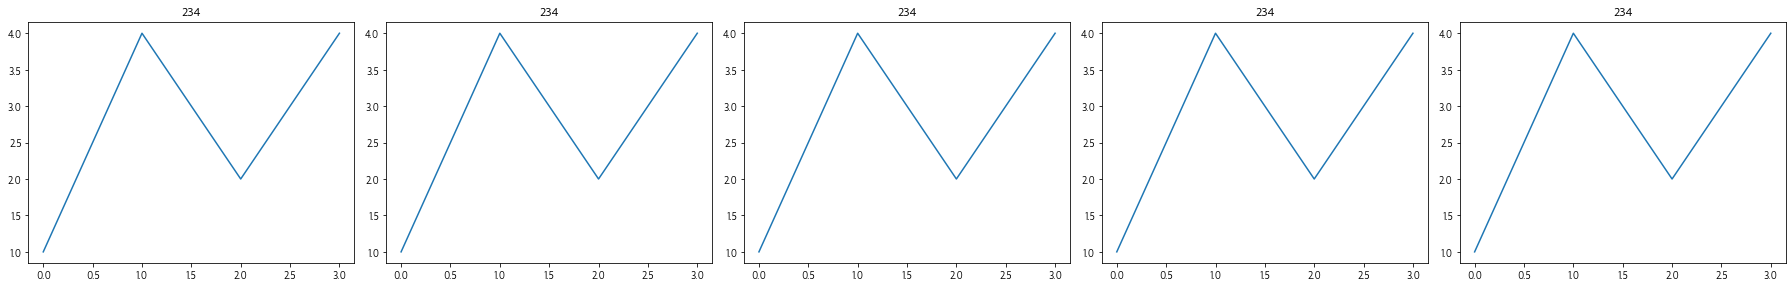

In [18]:
fig1 = plt.figure(figsize=(25,15), facecolor='white') 
fig2 = plt.figure(figsize=(25,15), facecolor='white') 

a = [[1,2,3,4], [4,2,3,3], [4,2,3,3], [4,2,3,3], [4,2,3,3]]
for i in range(5):
    ax1 = fig1.add_subplot(4,5,int(i)+1)
    ax1.plot(a[i])
    ax1.set_title('123')
    # ax1.xticks
    
    ax2 = fig2.add_subplot(4,5,int(i)+1)
    ax2.plot([1,4,2,4])
    ax2.set_title('234')

fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('asd.png')
fig2.savefig('sss.png')

#main file 결과 plot

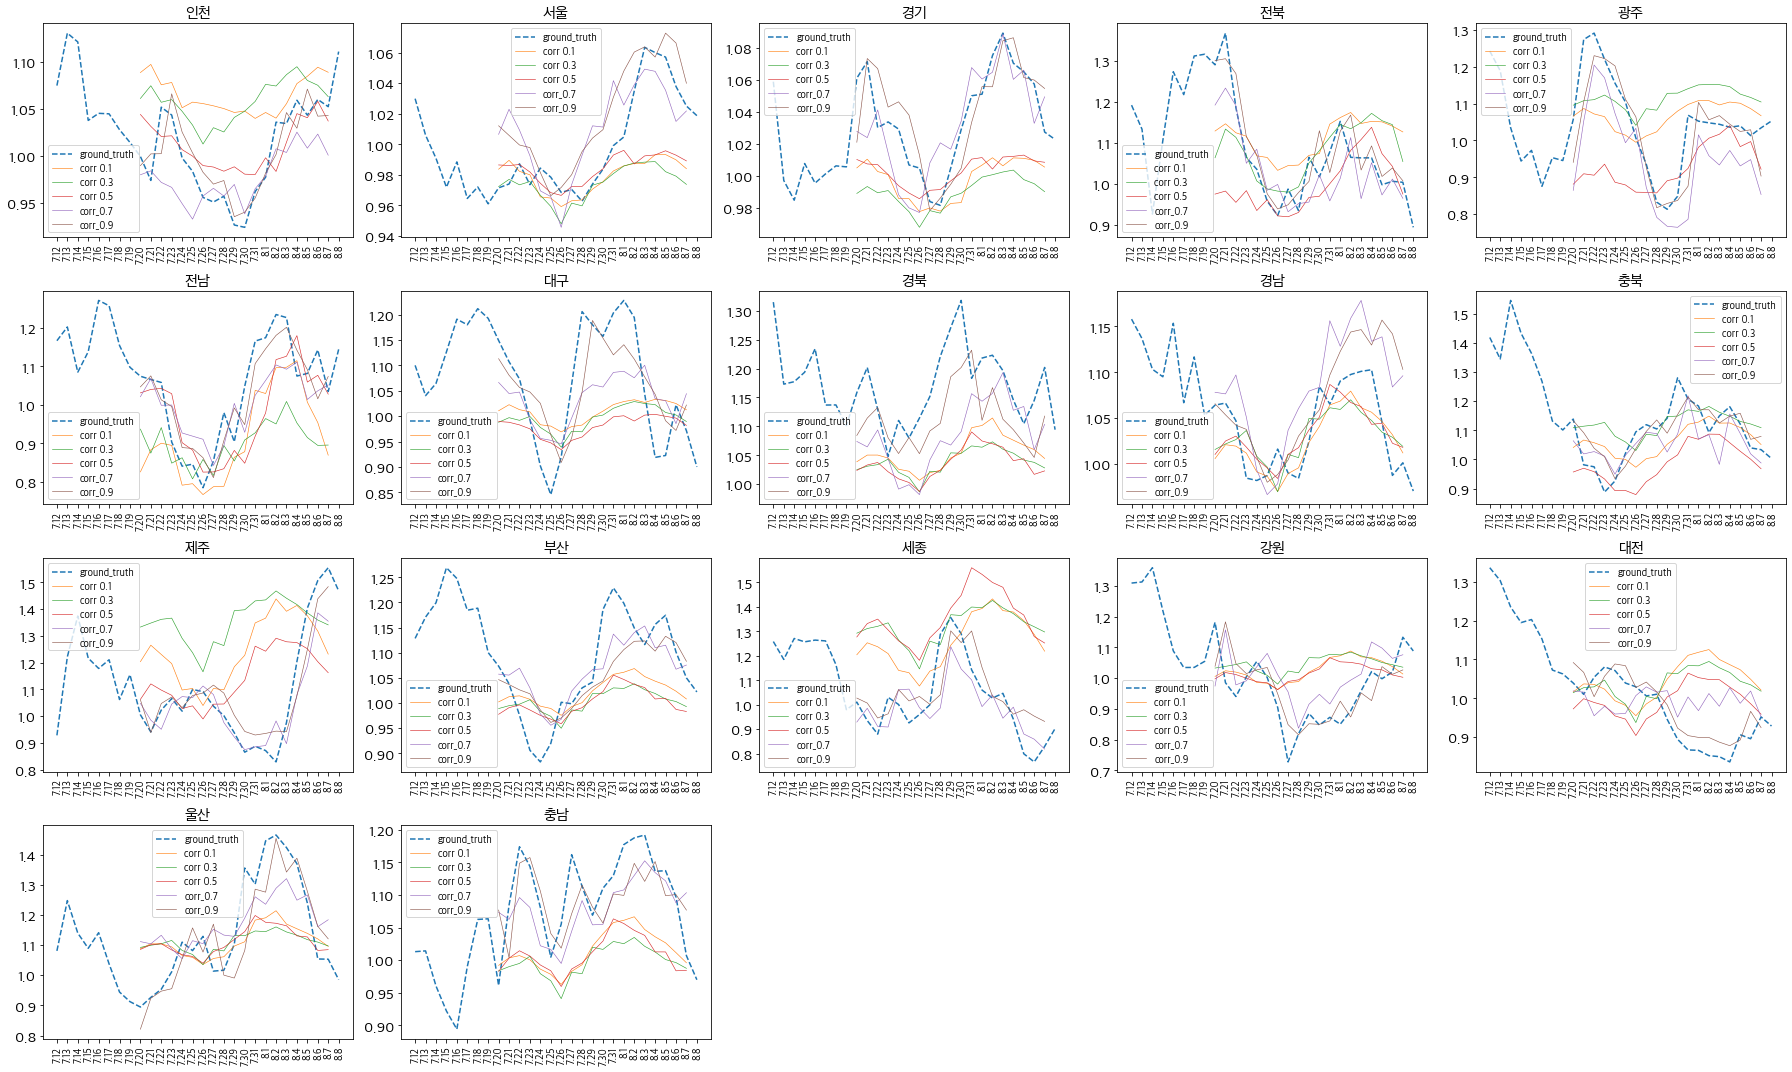

In [59]:
dist_1 = pd.read_csv('data/dist_0.1.csv')
dist_2 = pd.read_csv('data/dist_0.3.csv')
dist_3 = pd.read_csv('data/dist_0.5.csv')
dist_4 = pd.read_csv('data/dist_0.7.csv')
dist_5 = pd.read_csv('data/dist_0.9.csv')

corr_1 = pd.read_csv('data/corr_0.1.csv')
corr_2 = pd.read_csv('data/corr_0.3.csv')
corr_3 = pd.read_csv('data/corr_0.5.csv')
corr_4 = pd.read_csv('data/corr_0.7.csv')
corr_5 = pd.read_csv('data/corr_0.9.csv')

fig = plt.figure(figsize=(25,15), facecolor='white')
sequence_length = 8
for i in range(17):
    fig.add_subplot(4,5,int(i)+1)

    dist_1p = [None]*sequence_length + list(dist_1[str(i)])
    dist_2p = [None]*sequence_length + list(dist_2[str(i)])
    dist_3p = [None]*sequence_length + list(dist_3[str(i)])
    dist_4p = [None]*sequence_length + list(dist_4[str(i)])
    dist_5p = [None]*sequence_length + list(dist_5[str(i)])
    
    corr_1p = [None]*sequence_length + list(corr_1[str(i)])
    corr_2p = [None]*sequence_length + list(corr_2[str(i)])
    corr_3p = [None]*sequence_length + list(corr_3[str(i)])
    corr_4p = [None]*sequence_length + list(corr_4[str(i)])
    corr_5p = [None]*sequence_length + list(corr_5[str(i)])

    plt.plot(df[str(i)][len_train + len_val:].values,'--')
    # plt.plot(dist_1p,linewidth=0.6)
    # plt.plot(dist_2p,linewidth=0.6)
    # plt.plot(dist_3p,linewidth=0.6)
    # plt.plot(dist_4p,linewidth=0.6)
    # plt.plot(dist_5p,linewidth=0.6)
    # plt.legend(['ground_truth', 'dist 0.1', 'dist 0.3', 'dist 0.5', 'dist_0.7', 'dist_0.9'])
    
    plt.plot(corr_1p,linewidth=0.6)
    plt.plot(corr_2p,linewidth=0.6)
    plt.plot(corr_3p,linewidth=0.6)
    plt.plot(corr_4p,linewidth=0.6)
    plt.plot(corr_5p,linewidth=0.6)
    plt.legend(['ground_truth', 'corr 0.1', 'corr 0.3', 'corr 0.5', 'corr_0.7', 'corr_0.9'])
    
    xlabels = [i[5:] for i in list(df.index[len_train + len_val:])]
    plt.xticks(ticks = [i for i in range(len(xlabels))], labels = xlabels, rotation=90)
    plt.yticks(fontsize = 15)
    plt.title(enc[int(i)], fontsize = 15)
    
plt.tight_layout()
plt.savefig('result_corr.png')

# 다른거

In [63]:
import networkx as nx
import dgl

In [64]:
class KoreaNetwork():
    '''
    To fill text
    '''
    def __init__(self, data, region_type, save_path):
        self.data = data
        self.save_path = save_path
        self.type = region_type
        
    def make_network(self, threshold = 0.3, draw=True):
        self.adj_matrix = (self.data.corr(method='pearson') > threshold).astype(int)
        # print(self.data.corr(method='pearson'))
        self.corrmat = self.adj_matrix
        self.G = nx.Graph(self.corrmat)
        A = nx.adjacency_matrix(self.G)
        print(self.corrmat)
        if draw==True:
            plt.figure(figsize=(12,12))
            nx.draw(self.G)
            nx.draw_networkx_labels(self.G, pos=nx.spring_layout(self.G))
            # print(self.save_path)
            plt.savefig(f"{self.save_path}/Figures/{self.type}_network.png")
            
        
        self.edge_df = nx.to_pandas_edgelist(self.G)
        self.edge_df.drop('weight', axis=1, inplace=True)
        self.edge_df = self.edge_df.transpose()
        
        return self.G, self.edge_df, A.todense()

# Torch Geometric Temporal Test

In [300]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()
# loader = EnglandCovidDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
    
from tqdm import tqdm

model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

100%|██████████| 200/200 [00:22<00:00,  8.98it/s]


MSE: 1.0328


In [198]:
dataset.targets[0]

array([ 0.71056554, -0.07246925,  2.60994445,  1.78704255,  0.80241278,
       -0.26138472, -0.83701737,  1.96743276, -0.42117366,  0.16546514,
        1.25194474,  2.37428818,  0.78765172,  0.45314763, -0.17210651,
       -0.06139673,  1.04517855,  0.32032987, -1.37910947,  0.00358903])

In [199]:
dataset.targets[1]

array([-0.6830763 ,  1.01702123,  1.61028185, -0.84426894, -0.32784778,
        1.2842631 ,  1.05795714, -2.47521333, -0.79097002, -0.16578304,
       -0.25622081, -2.02874208, -0.85085458, -0.56305105,  1.95765936,
        0.97655214, -0.36798241, -1.00023329,  3.90929962,  0.43844544])

In [204]:
tg = np.array(dataset.targets).transpose()

In [206]:
for time, snapshot in enumerate(dataset):
    # print(snapshot.x.shape, snapshot.y.shape, time)
    print(snapshot.y)
    if time == 2:
        break

tensor([ 0.7106, -0.0725,  2.6099,  1.7870,  0.8024, -0.2614, -0.8370,  1.9674,
        -0.4212,  0.1655,  1.2519,  2.3743,  0.7877,  0.4531, -0.1721, -0.0614,
         1.0452,  0.3203, -1.3791,  0.0036])
tensor([-0.6831,  1.0170,  1.6103, -0.8443, -0.3278,  1.2843,  1.0580, -2.4752,
        -0.7910, -0.1658, -0.2562, -2.0287, -0.8509, -0.5631,  1.9577,  0.9766,
        -0.3680, -1.0002,  3.9093,  0.4384])
tensor([ 0.2954, -1.0868, -0.7089, -0.1605, -0.5911, -0.2943,  0.4532,  2.2426,
         0.2615,  0.8280,  0.8841,  0.6922,  0.5762,  1.2205, -1.4760, -0.3130,
        -0.7867,  1.5498, -0.1501, -0.6922])


In [183]:
edgelist = pd.DataFrame({'from' : train_dataset.edge_index[0],
                        'to' : train_dataset.edge_index[1],
                        'attr' : train_dataset.edge_weight})

print(edgelist.shape)
G = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr='attr')
print(G.degree)
print(len(G.nodes))

(102, 3)
[(0, 8), (10, 9), (6, 8), (13, 9), (1, 5), (5, 5), (16, 6), (14, 7), (2, 5), (8, 6), (3, 7), (15, 4), (12, 5), (9, 6), (4, 3), (11, 6), (18, 8), (7, 5), (17, 5), (19, 5)]
20


In [180]:
import networkx as nx
import matplotlib.pyplot as plt
# 그래프는 고정이고 노드 값들이 바뀌는건가

for time, snapshot in enumerate(train_dataset):
    plt.figure(time+1)
    edgelist = pd.DataFrame({'from' : train_dataset.edge_indices[time][0],
                            'to' : train_dataset.edge_indices[time][1],
                            'attr' : train_dataset.edge_weights[time]})
    # print(time)
    # print(snapshot.x.shape)
    print(edgelist.shape)
    G = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr='attr')
    print(G.degree)

ValueError: If using all scalar values, you must pass an index

<Figure size 432x288 with 0 Axes>

# Dynamic Graph Conv

In [247]:
from torch_geometric_temporal.signal import dynamic_graph_temporal_signal

In [261]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal

# 여기에 super를 써서 다 지우고 get_target_and_feature만 바꿔줄수이씅ㄹ까??
class EngCovidData(EnglandCovidDatasetLoader):
    
    def __init__(self):
        super().__init__()

    def _read_web_data(self):
        super()._read_web_data()
        # url = "https://raw.githubusercontent.com/benedekrozemberczki/pytorch_geometric_temporal/master/dataset/england_covid.json"
        # self._dataset = json.loads(urllib.request.urlopen(url).read())
        
    def _get_edges(self):
        super()._get_edges()
        # self._edges = []
        # for time in range(self._dataset["time_periods"] - self.lags):
        #     self._edges.append(
        #         np.array(self._dataset["edge_mapping"]["edge_index"][str(time)]).T
        #     )

    def _get_edge_weights(self):
        super()._get_edge_weights()
        # self._edge_weights = []
        # for time in range(self._dataset["time_periods"] - self.lags):
        #     self._edge_weights.append(
        #         np.array(self._dataset["edge_mapping"]["edge_weight"][str(time)])
        #     )

    def _get_targets_and_features(self):

        stacked_target = np.array(self._dataset["y"])
        standardized_target = (stacked_target - np.mean(stacked_target, axis=0)) / (
            np.std(stacked_target, axis=0) + 10 ** -10
        )
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(self._dataset["time_periods"] - self.lags)
        ]
        
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(self._dataset["time_periods"] - self.lags)
        ]
        
        return np.mean(stacked_target, axis=0), np.std(stacked_target, axis=0)

    def get_dataset(self, lags: int = 8) -> DynamicGraphTemporalSignal:
        """Returning the England COVID19 data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The England Covid dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = DynamicGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset


In [405]:
torch.abs()

TypeError: abs(): argument 'input' (position 1) must be Tensor, not list

In [429]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DyGrEncoder

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

# loader = EnglandCovidDatasetLoader()
loader = EngCovidData()
dataset = loader.get_dataset(lags=4)
mean, std = loader._get_targets_and_features()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DyGrEncoder(conv_out_channels=8, conv_num_layers=1, conv_aggr="mean", lstm_out_channels=32, lstm_num_layers=1)
        # self.recurrent2 = DyGrEncoder(conv_out_channels=8, conv_num_layers=1, conv_aggr="mean", lstm_out_channels=32, lstm_num_layers=1)
        self.linear = torch.nn.Linear(32, 1)
        self.linear2 = torch.nn.Linear(1, 129)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_weight, h_0, c_0):
        # print(x.size(-1), h_0, c_0)
        h, h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h_0, c_0)
        # h, h_0, c_0 = self.recurrent2(x, edge_index, edge_weight, h_0, c_0)
        h = self.dropout(h)
        h = F.relu(h)
        h = self.linear(h)
        # h = F.relu(h)
        # h = self.linear2(h)
        return h, h_0, c_0
        
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    
    h, c = None,None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    
    
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
print(time+1)
model.eval()
cost = 0
error = 0
h, c = None, None

ground_truth = []
pred = []

for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    error = error + torch.sum(torch.abs((y_hat-snapshot.y)))
    
    ground_truth.append(snapshot.y.detach().numpy() * (std + 10 ** -10)+ mean)
    pred.append((y_hat.detach().numpy().T * (std + 10 ** -10) + mean)[0])
    
cost = cost / (time+1) # test dataset에서의 날짜 수 만큼 나눠줌(time이 0부터 시작) : 다음날 예측에 대한 MSE
error = error / (snapshot.y.shape[0]*(time+1)) # test dataset에서의 날짜 수 만큼 나눠줌(time이 0부터 시작) : 다음날 예측에 대한 MSE
cost = cost.item()
error = error.item()
print(time+1)
print("MSE: {:.4f}".format(cost))
print("ERROR: {:.4f}".format(error))

100%|██████████| 200/200 [00:15<00:00, 13.17it/s]

45
12
MSE: 0.6621
ERROR: 87.2878


9

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not support 'g' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Legend does not supp

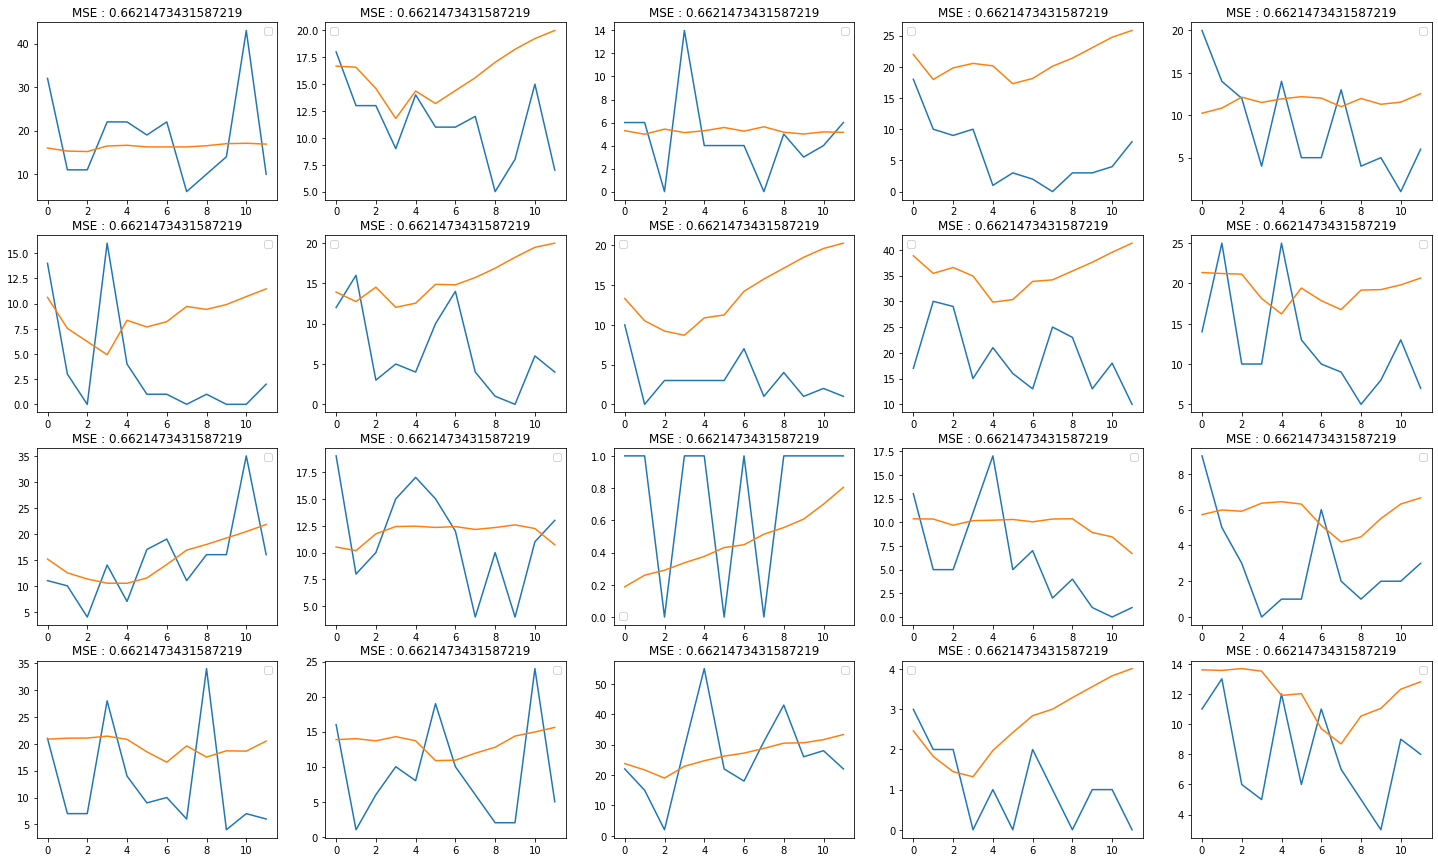

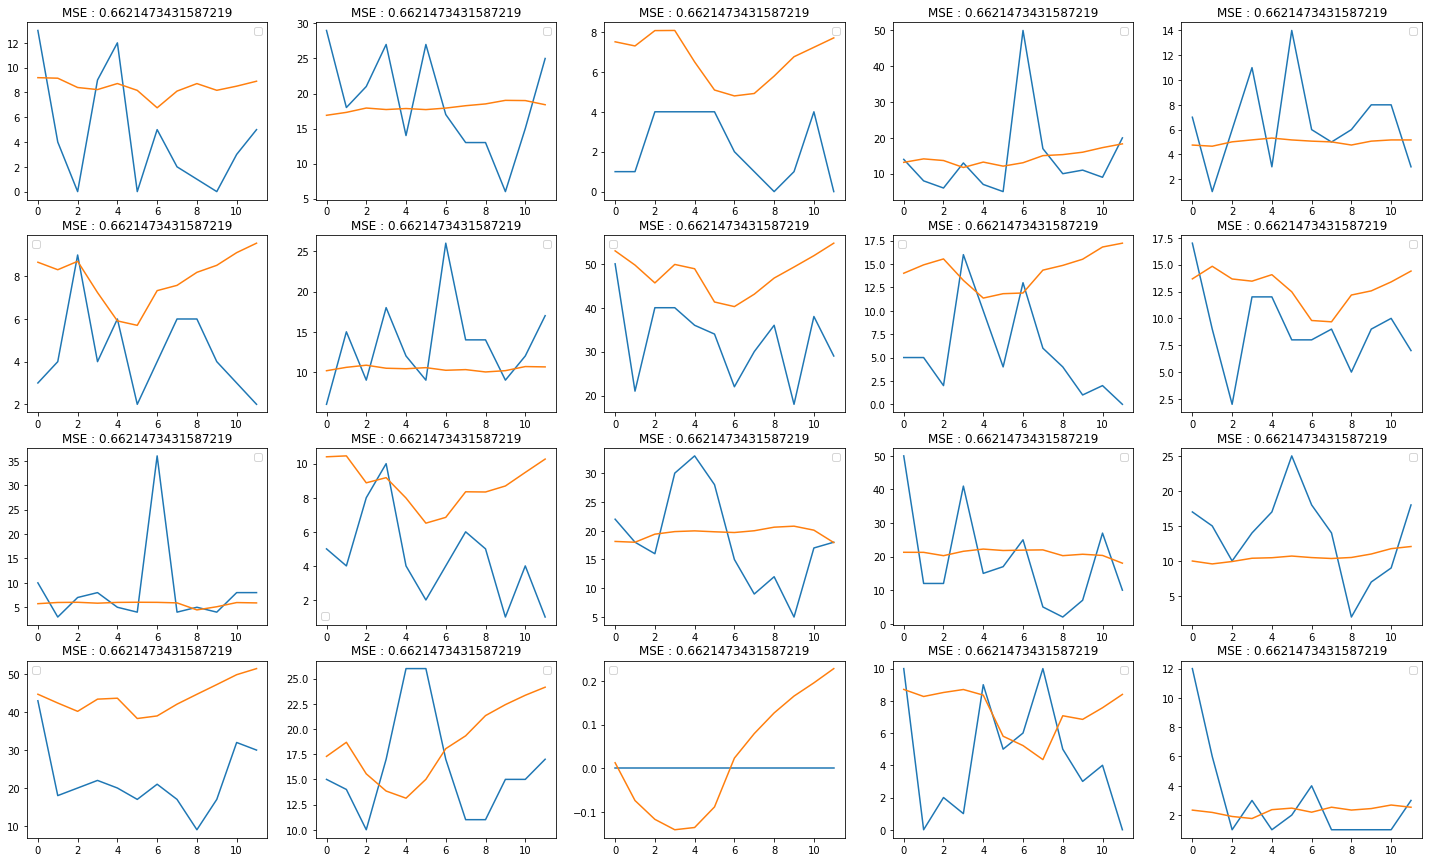

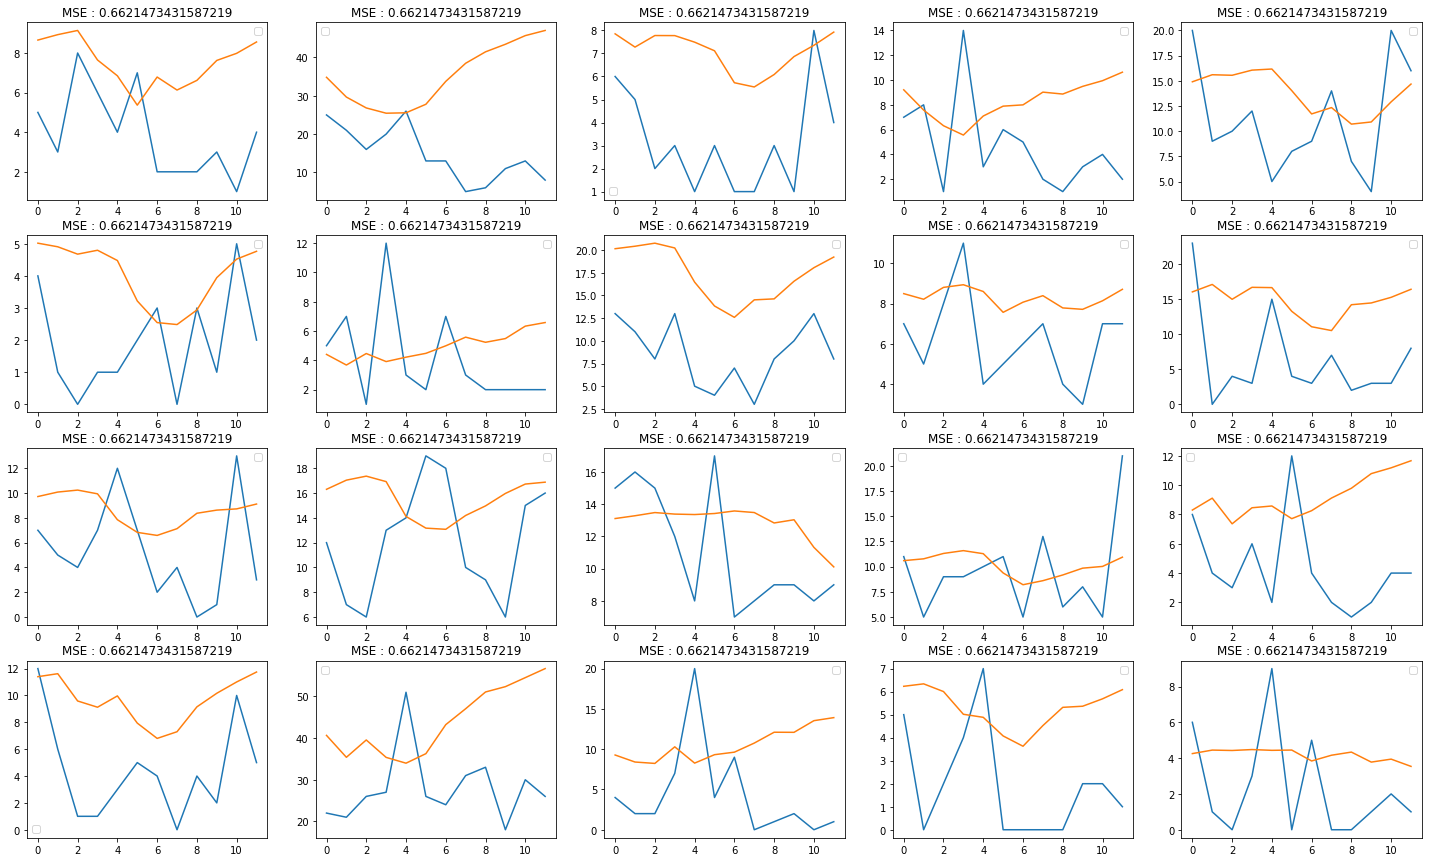

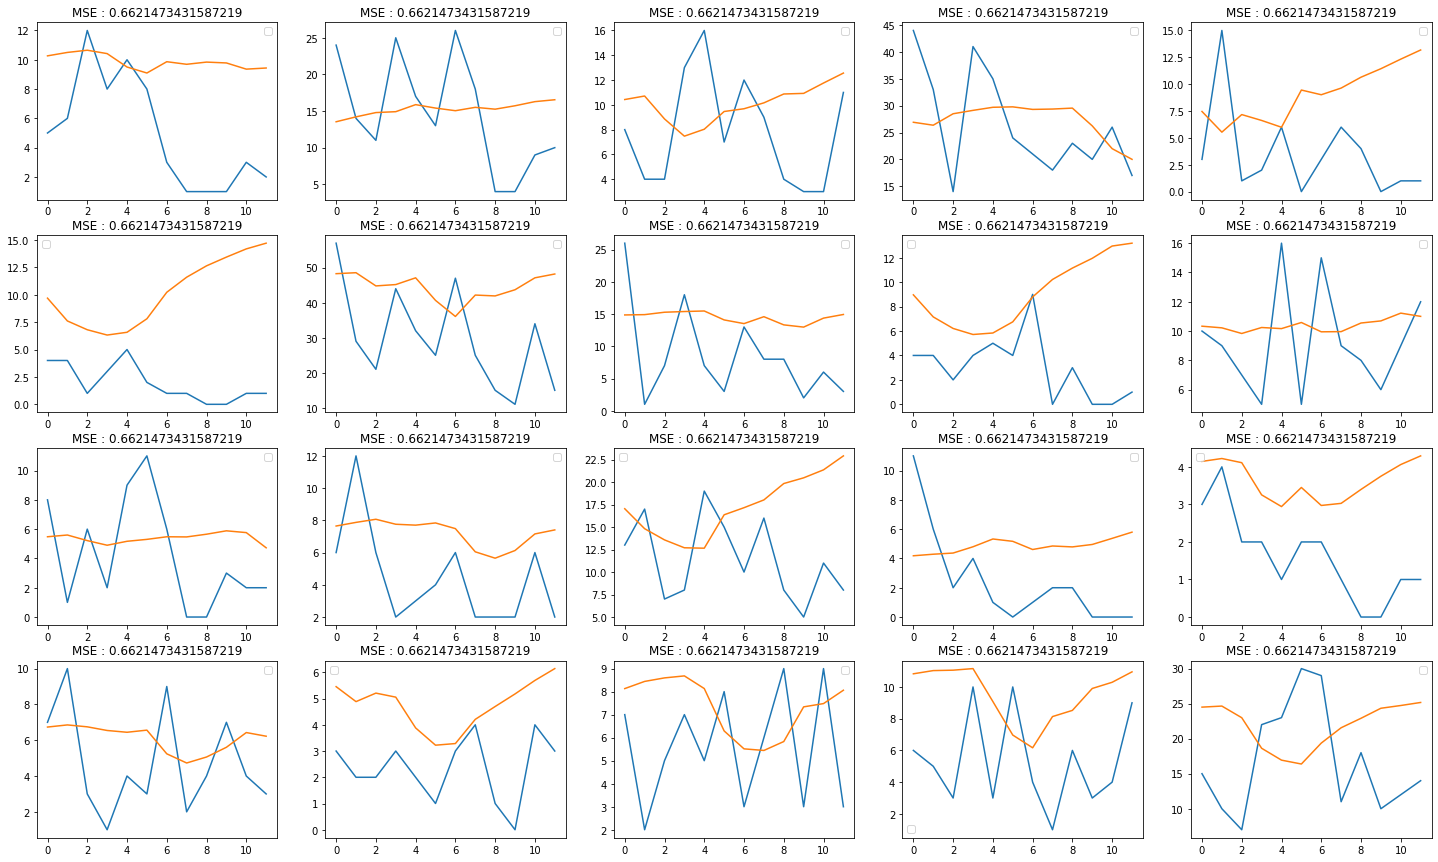

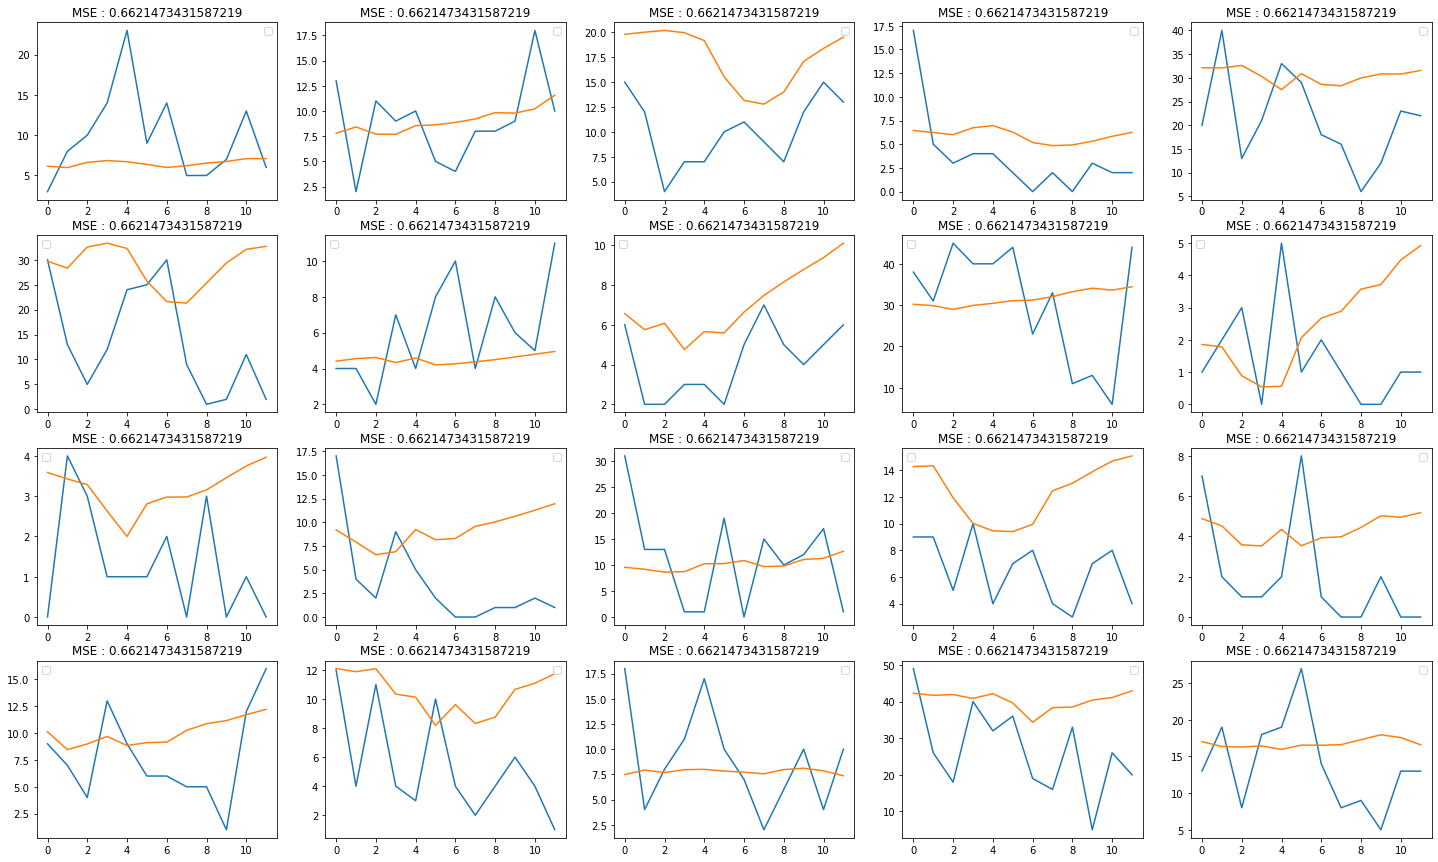

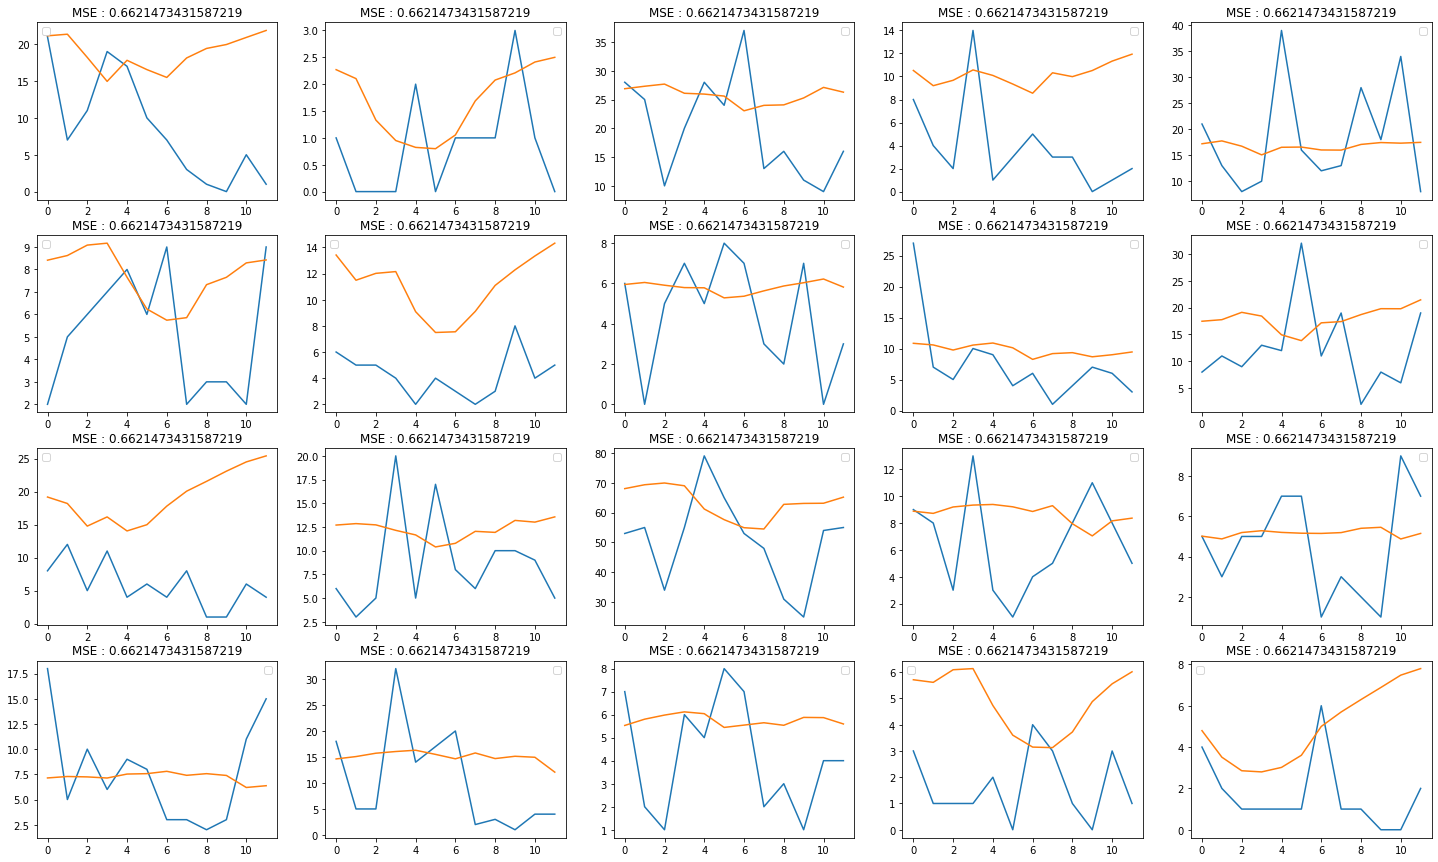

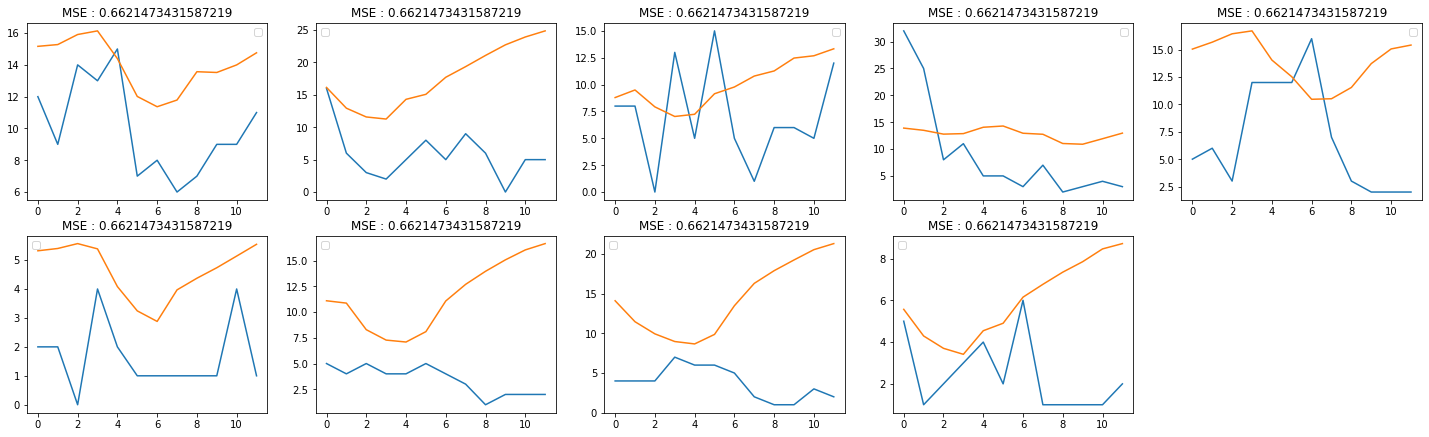

In [430]:
from math import ceil
grth_ = [[] for i in range(len(ground_truth[0]))]
pred_ = [[] for i in range(len(pred[0]))]

for time in range(len(ground_truth)):
    for i in range(len(ground_truth[0])):
        grth_[i].append(ground_truth[time][i])
        pred_[i].append(pred[time][i])


# base figure 정의해주고
for num in range(ceil(len(ground_truth[0])/20)):
    fig = plt.figure(figsize=(25,15), facecolor='white')
    
    # 20개 이상인 지역들을 다른 figure에 plot 하기 위해 범위를 나눠줌
    if num == 0:
        range_ = range(20)
    elif 20*(num+1) > len(ground_truth[0]): # 마지막이 20의 배수보다 작으면
        range_ = range(20*num, len(ground_truth[0]))
    else:
        range_ = range(20*num, 20*(num+1))

    for i in range_: # 17 도시에 대해서 각 도, 66개 수도권 시군구에 대해서 시군구
        if i<20:
            fig.add_subplot(4,5,i+1)
        elif i<40:
            fig.add_subplot(4,5,i-19)
        elif i<60:
            fig.add_subplot(4,5,i-39)
        elif i<80:
            fig.add_subplot(4,5,i-59)
        elif i<100:
            fig.add_subplot(4,5,i-79)
        elif i<120:
            fig.add_subplot(4,5,i-99)
        elif i<140:
            fig.add_subplot(4,5,i-119)
        elif i<160:
            fig.add_subplot(4,5,i-139)
        
        plt.plot(grth_[i])
        plt.plot(pred_[i])
        plt.legend("ground_truth", "predict")
        plt.title(f"MSE : {cost}") # 각 지역별 MSE가 아닌 전체에 대한 MSE




In [293]:
from pyvis.network import Network
for i in range(len(dataset.edge_indices)):
    # 데이터의 형태는 [[[1일차 from], [to]], [[2일차 from], [to]] ...]
    df = pd.DataFrame({'from' : dataset.edge_indices[i][0],
                      'to' : dataset.edge_indices[i][1]})
    
    nt3 = Network("1000px", "1500px", directed=False, heading= str(i), bgcolor='#222222', font_color='white')
    G = nx.from_pandas_edgelist(df, source='from', target='to')
    # print(corrmat)
    nt3.from_nx(G)
    nt3.show_buttons(filter_=['physics'])
    nt3.toggle_physics(True)
    nt3.show(f"test_dynamic/{i}_.html")